<a href="https://colab.research.google.com/github/Shreyash54/HealthMisinfoDetection/blob/main/SEM7_RNN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
dataframe = pd.read_csv('cleaned_dataset.csv')
dataframe.head()

,id,statement,description,rating
0,6771.0,Dawn dish soap contains ammonia even though it...,Could Mixing Dawn Dish Soap with Clorox Bleach...,mixture
1,2468.0,Is blue light harmful to our eyes?,It seems reasonable to reduce exposure to blue...,unproven
2,1929.0,Are the 'Winter Blues' real?,"I've recently <a href=""https://www.sciencedail...",TRUE
3,1872.0,Is air pollution linked to greater risk of dem...,"<a href=""https://www.theguardian.com/environme...",TRUE
4,1956.0,Can eccentric exercises cause human hyperplasia?,With concentric regular exercises muscle hyper...,unproven


In [ ]:
dataframe['rating'] = dataframe['rating'].replace('mixture', 'TRUE')
dataframe['rating'] = dataframe['rating'].replace('unproven', 'TRUE')
dataframe['rating'] = dataframe['rating'].replace('mostly-true', 'TRUE')
dataframe['rating'] = dataframe['rating'].replace('mostly-false', 'FALSE')

In [ ]:
dataframe.head()

,id,statement,description,rating
0,6771.0,Dawn dish soap contains ammonia even though it...,Could Mixing Dawn Dish Soap with Clorox Bleach...,TRUE
1,2468.0,Is blue light harmful to our eyes?,It seems reasonable to reduce exposure to blue...,TRUE
2,1929.0,Are the 'Winter Blues' real?,"I've recently <a href=""https://www.sciencedail...",TRUE
3,1872.0,Is air pollution linked to greater risk of dem...,"<a href=""https://www.theguardian.com/environme...",TRUE
4,1956.0,Can eccentric exercises cause human hyperplasia?,With concentric regular exercises muscle hyper...,TRUE


In [ ]:
dataframe.rating.value_counts()

rating
FALSE    353
TRUE     330
Name: count, dtype: int64

RNN Implementation

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [ ]:
num_of_categories = 1000
shuffled = dataframe.reindex(np.random.permutation(dataframe.index))
TRUE = shuffled[shuffled['rating'] == 'TRUE'][:num_of_categories]
FALSE = shuffled[shuffled['rating'] == 'FALSE'][:num_of_categories]
concated = pd.concat([TRUE,FALSE], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [ ]:
concated.loc[concated['rating'] == 'TRUE', 'LABEL'] = 0
concated.loc[concated['rating'] == 'FALSE', 'LABEL'] = 1
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=2)
print(labels[:10])
if 'rating' in concated.keys():
    concated.drop(['rating'], axis=1)

476    1
53     0
410    1
414    1
544    1
119    0
614    1
89     0
422    1
355    1
Name: LABEL, dtype: int64
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [ ]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['statement'].values)
sequences = tokenizer.texts_to_sequences(concated['statement'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 2548 unique tokens.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [ ]:
epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

array([[0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=10, batch_size=50,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0)])

((512, 130), (512, 2), (171, 130), (171, 2))
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 128)          1024000   
                                                                 
 spatial_dropout1d (Spatial  (None, 130, 128)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 1073538 (4.10 MB)
Trainable params: 1073538 (4.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
9/9 [==================

In [ ]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6/6 [==============================] - 0s 14ms/step - loss: 0.4190 - acc: 0.8187
Test set
  Loss: 0.419
  Accuracy: 0.819


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
# Evaluation Metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

precision, recall, f1_score, support = precision_recall_fscore_support(y_test_classes, y_pred_classes, average='weighted')
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1_score))
print("Support: {}".format(support))

6/6 [==============================] - 0s 14ms/step
Precision: 0.84
Recall: 0.82
F1 Score: 0.82
Support: None


In [ ]:
from sklearn.metrics import classification_report

# Generate predictions on the test data
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions to class labels (assuming y_pred is one-hot encoded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels to class labels (assuming y_test is one-hot encoded)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes)

# Print the classification report
print(report)

6/6 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

           0       0.91      0.72      0.80        88
           1       0.75      0.93      0.83        83

    accuracy                           0.82       171
   macro avg       0.83      0.82      0.82       171
weighted avg       0.84      0.82      0.82       171



In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(y_true_classes, y_pred_classes)

# Extract TP, FP, TN, FN from the confusion matrix
TP = confusion_matrix_result[1, 1]  # True Positives
FP = confusion_matrix_result[0, 1]  # False Positives
TN = confusion_matrix_result[0, 0]  # True Negatives
FN = confusion_matrix_result[1, 0]  # False Negatives

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

True Positives (TP): 77
False Positives (FP): 25
True Negatives (TN): 63
False Negatives (FN): 6


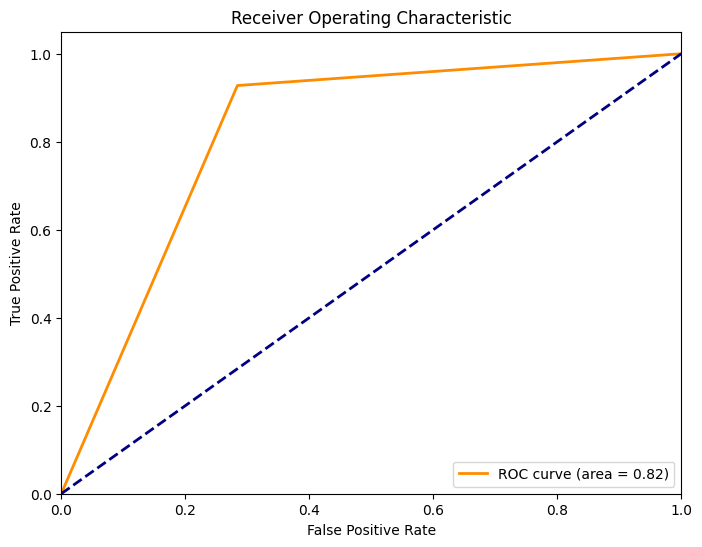

AUC (Area Under the ROC Curve): 0.8218099671412923


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# ... (your model training and evaluation code)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_true_classes, y_pred_classes)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true_classes, y_pred_classes)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print(f"AUC (Area Under the ROC Curve): {roc_auc}")


In [ ]:
y_pred

array([[0.7316561 , 0.26834393],
       [0.82932365, 0.17067632],
       [0.8317153 , 0.16828471],
       [0.32453677, 0.6754632 ],
       [0.30666682, 0.6933332 ],
       [0.72588027, 0.27411965],
       [0.24595068, 0.75404924],
       [0.84558606, 0.15441391],
       [0.20612413, 0.7938758 ],
       [0.16592738, 0.83407265],
       [0.05025645, 0.94974357],
       [0.16386782, 0.83613217],
       [0.7450068 , 0.25499317],
       [0.48101932, 0.5189806 ],
       [0.9156    , 0.08440007],
       [0.85584795, 0.14415206],
       [0.9297868 , 0.07021318],
       [0.65154624, 0.34845376],
       [0.8021578 , 0.19784214],
       [0.21694371, 0.7830563 ],
       [0.47040835, 0.5295917 ],
       [0.46829545, 0.5317045 ],
       [0.81541   , 0.18458997],
       [0.24120025, 0.7587997 ],
       [0.81921107, 0.18078896],
       [0.20763838, 0.7923616 ],
       [0.76765877, 0.23234129],
       [0.67561233, 0.32438767],
       [0.80788374, 0.19211629],
       [0.8402722 , 0.1597278 ],
       [0.

In [ ]:
y_test

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.

In [ ]:
txt = ["Does taking apple cider vinegar as a supplement have any real health benefits?"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['TRUE', 'FALSE']
print(labels[np.argmax(pred)])

1/1 [==============================] - 0s 40ms/step
TRUE


In [ ]:
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1).astype("int64")
labels = to_categorical(concated['LABEL'], num_classes=2)
labels[labels == [1.,0.]]= [0]
labels[labels == [0.,1.]]= [1]
y_true = labels


1/6 [====>.........................] - ETA: 0s

6/6 [==============================] - 0s 22ms/step


In [ ]:
y_true

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float32)

In [ ]:
y_pred

array([[8.92487407e-01, 1.07512526e-01],
       [9.81541276e-01, 1.84587222e-02],
       [9.62307870e-01, 3.76921184e-02],
       [4.25669402e-01, 5.74330568e-01],
       [5.45263290e-01, 4.54736710e-01],
       [8.19454372e-01, 1.80545613e-01],
       [1.43490866e-01, 8.56509149e-01],
       [9.86863494e-01, 1.31365443e-02],
       [5.21594519e-03, 9.94784057e-01],
       [2.39971280e-03, 9.97600257e-01],
       [1.96597283e-03, 9.98034060e-01],
       [4.84752329e-03, 9.95152473e-01],
       [9.46608961e-01, 5.33910394e-02],
       [4.49594185e-02, 9.55040634e-01],
       [9.97592211e-01, 2.40777642e-03],
       [9.93793845e-01, 6.20619347e-03],
       [9.97361124e-01, 2.63890298e-03],
       [4.77600724e-01, 5.22399247e-01],
       [5.18200994e-01, 4.81798977e-01],
       [6.05638837e-03, 9.93943632e-01],
       [9.23965514e-01, 7.60345012e-02],
       [9.78786767e-01, 2.12131869e-02],
       [8.85970294e-01, 1.14029661e-01],
       [2.81160269e-02, 9.71884012e-01],
       [9.043661

In [ ]:
def rnn_det(txt):
    input_data = [txt]
    seq = tokenizer.texts_to_sequences(input_data)
    padded = pad_sequences(seq)
    prediction = model.predict(padded)
    labels = ['TRUE', 'FALSE']
    print(labels[np.argmax(prediction)])

In [ ]:
rnn_det("Antibodies for the common cold produce a positive COVID-19 test; false-positive results from COVID-19 antibody testing are behind the COVID-19 cases reported in the U.S.")

1/1 [==============================] - 0s 250ms/step
FALSE


In [ ]:
# imports
from tensorflow.keras.models import model_from_json


model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")



Saved model to disk


Epoch 1/10
2/2 [==============================] - 1s 382ms/step - loss: 0.0367 - acc: 0.9902 - val_loss: 0.3493 - val_acc: 0.8641
Epoch 2/10
2/2 [==============================] - 1s 338ms/step - loss: 0.0353 - acc: 0.9878 - val_loss: 0.3477 - val_acc: 0.8544
Epoch 3/10
2/2 [==============================] - 1s 339ms/step - loss: 0.0264 - acc: 0.9976 - val_loss: 0.3475 - val_acc: 0.8544
Epoch 4/10
2/2 [==============================] - 1s 346ms/step - loss: 0.0352 - acc: 0.9927 - val_loss: 0.3472 - val_acc: 0.8544
Epoch 5/10
2/2 [==============================] - 1s 356ms/step - loss: 0.0221 - acc: 0.9976 - val_loss: 0.3485 - val_acc: 0.8447
Epoch 6/10
2/2 [==============================] - 1s 337ms/step - loss: 0.0319 - acc: 0.9902 - val_loss: 0.3532 - val_acc: 0.8544
Epoch 7/10
2/2 [==============================] - 1s 365ms/step - loss: 0.0227 - acc: 0.9976 - val_loss: 0.3603 - val_acc: 0.8350
Epoch 8/10
2/2 [==============================] - 1s 355ms/step - loss: 0.0294 - acc: 0.99

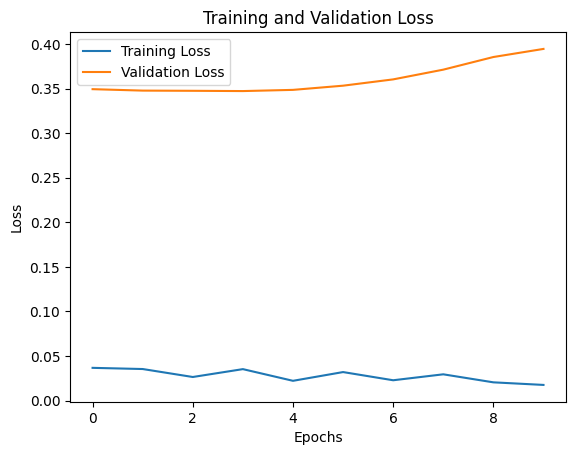

In [ ]:
import matplotlib.pyplot as plt


history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

# Plotting the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/10
2/2 [==============================] - 1s 402ms/step - loss: 0.0265 - acc: 0.9951 - val_loss: 0.3945 - val_acc: 0.8447
Epoch 2/10
2/2 [==============================] - 1s 347ms/step - loss: 0.0270 - acc: 0.9902 - val_loss: 0.3839 - val_acc: 0.8447
Epoch 3/10
2/2 [==============================] - 1s 317ms/step - loss: 0.0233 - acc: 0.9976 - val_loss: 0.3764 - val_acc: 0.8544
Epoch 4/10
2/2 [==============================] - 1s 320ms/step - loss: 0.0306 - acc: 0.9902 - val_loss: 0.3720 - val_acc: 0.8641
Epoch 5/10
2/2 [==============================] - 1s 299ms/step - loss: 0.0272 - acc: 0.9927 - val_loss: 0.3731 - val_acc: 0.8641
Epoch 6/10
2/2 [==============================] - 1s 298ms/step - loss: 0.0294 - acc: 0.9927 - val_loss: 0.3768 - val_acc: 0.8641
Epoch 7/10
2/2 [==============================] - 1s 313ms/step - loss: 0.0282 - acc: 0.9951 - val_loss: 0.3790 - val_acc: 0.8544
Epoch 8/10
2/2 [==============================] - 1s 319ms/step - loss: 0.0262 - acc: 0.98

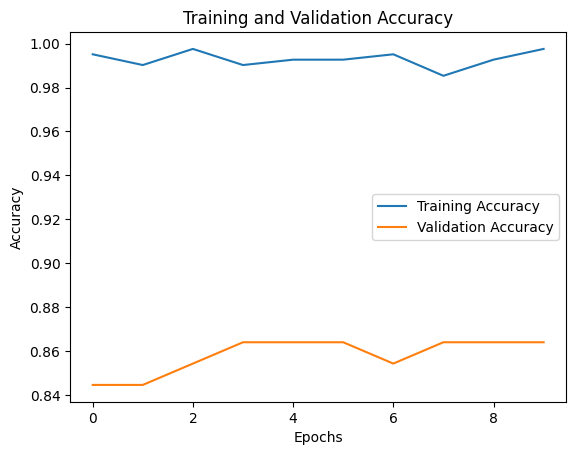

In [ ]:
import matplotlib.pyplot as plt



history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

# Plotting the training accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ... (previous code remains unchanged) ...

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

# Evaluation Metrics
y_pred = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
lw = 2
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()





Epoch 1/10
2/2 [==============================] - 1s 341ms/step - loss: 0.0201 - acc: 0.9902 - val_loss: 0.3994 - val_acc: 0.8447
Epoch 2/10
2/2 [==============================] - 1s 319ms/step - loss: 0.0189 - acc: 0.9951 - val_loss: 0.4040 - val_acc: 0.8350
Epoch 3/10
2/2 [==============================] - 1s 326ms/step - loss: 0.0223 - acc: 0.9927 - val_loss: 0.4082 - val_acc: 0.8350
Epoch 4/10
2/2 [==============================] - 1s 336ms/step - loss: 0.0137 - acc: 0.9976 - val_loss: 0.4132 - val_acc: 0.8252
Epoch 5/10
2/2 [==============================] - 1s 312ms/step - loss: 0.0227 - acc: 0.9927 - val_loss: 0.4137 - val_acc: 0.8350
Epoch 6/10
2/2 [==============================] - 1s 333ms/step - loss: 0.0161 - acc: 0.9976 - val_loss: 0.4108 - val_acc: 0.8350
Epoch 7/10
2/2 [==============================] - 1s 343ms/step - loss: 0.0223 - acc: 0.9976 - val_loss: 0.4073 - val_acc: 0.8155
Epoch 8/10
6/6 [==============================] - 0s 26ms/step


IndexError: index 2 is out of bounds for axis 1 with size 2